**The notebook is designed for sky object checking for Merian DR1 data**

author: X.Lin
last updated: 2024-01-30


In [2]:
### load modules

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'


from qa_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
### visit Merian data repo

# Merian data repo
root = '/projects/MERIAN/repo'
butler = dafButler.Butler(root)

# Example


Perform the sky object checking in one tract
 

**STEP1** 

we need to get the tract and patch IDs for the region we want to look at.

We use the butler to get the tract and patch IDs for the coadd data.


In [11]:
list_tract_ids = [8765] # example tracts

dataset = {} # dict to keep key statistics for each tract
for tract_id in list_tract_ids:
    
    dataset[tract_id] = {}
    
    #---------------- 
    # Loop over patches to check the num of  visits for each tract
    #---------------- 
    visits_ids = []
    for i in range(6):
        print('Patch', i )
        for bandname in ['N708','N540']:
            img_id = {'tract': tract_id, 'patch': i, 'band': bandname}
            try:
                coadd_ = butler.get('deepCoadd_calexp',
                        dataId=img_id,
                        instrument='DECam',skymap='hsc_rings_v1',
                        collections='DECam/runs/merian/dr1_wide/20220930T192809Z')
            except LookupError:
                print('No data for ', img_id)
                continue
            visits = coadd_.getInfo().getCoaddInputs().visits['id']
            visits_ids += list(visits)
    visits_ids = np.unique(visits_ids)
    print('visit id list: ', visits_ids)


Patch 0
Patch 1
Patch 2
Patch 3
Patch 4
No data for  {'tract': 8765, 'patch': 4, 'band': 'N708'}
Patch 5
No data for  {'tract': 8765, 'patch': 5, 'band': 'N708'}
visit id list:  [1033056 1033057 1055215 1055216 1055516 1055522 1055708 1055709 1055918
 1055919 1055920 1055921 1055926]


**STEP2**

Then we obtain the coadd catalog of sky objects.


In [12]:
tract = 8765
collection = 'DECam/runs/merian/dr1_wide/20221006T145423Z'
skymap = 'hsc_rings_v1'

cat_coadd = butler.get( 'objectTable_tract', tract=tract, instrument='DECam',
                        skymap=skymap, collections=collection)
skyobj_cat = cat_coadd[cat_coadd.merge_peak_sky==True]


**STEP3**

Examine the sky object in one tract

Use the function `plot_coadd2d_oneTract` to plot statistics of sky objects in historgram and PATCH layout for coadds of tracts.

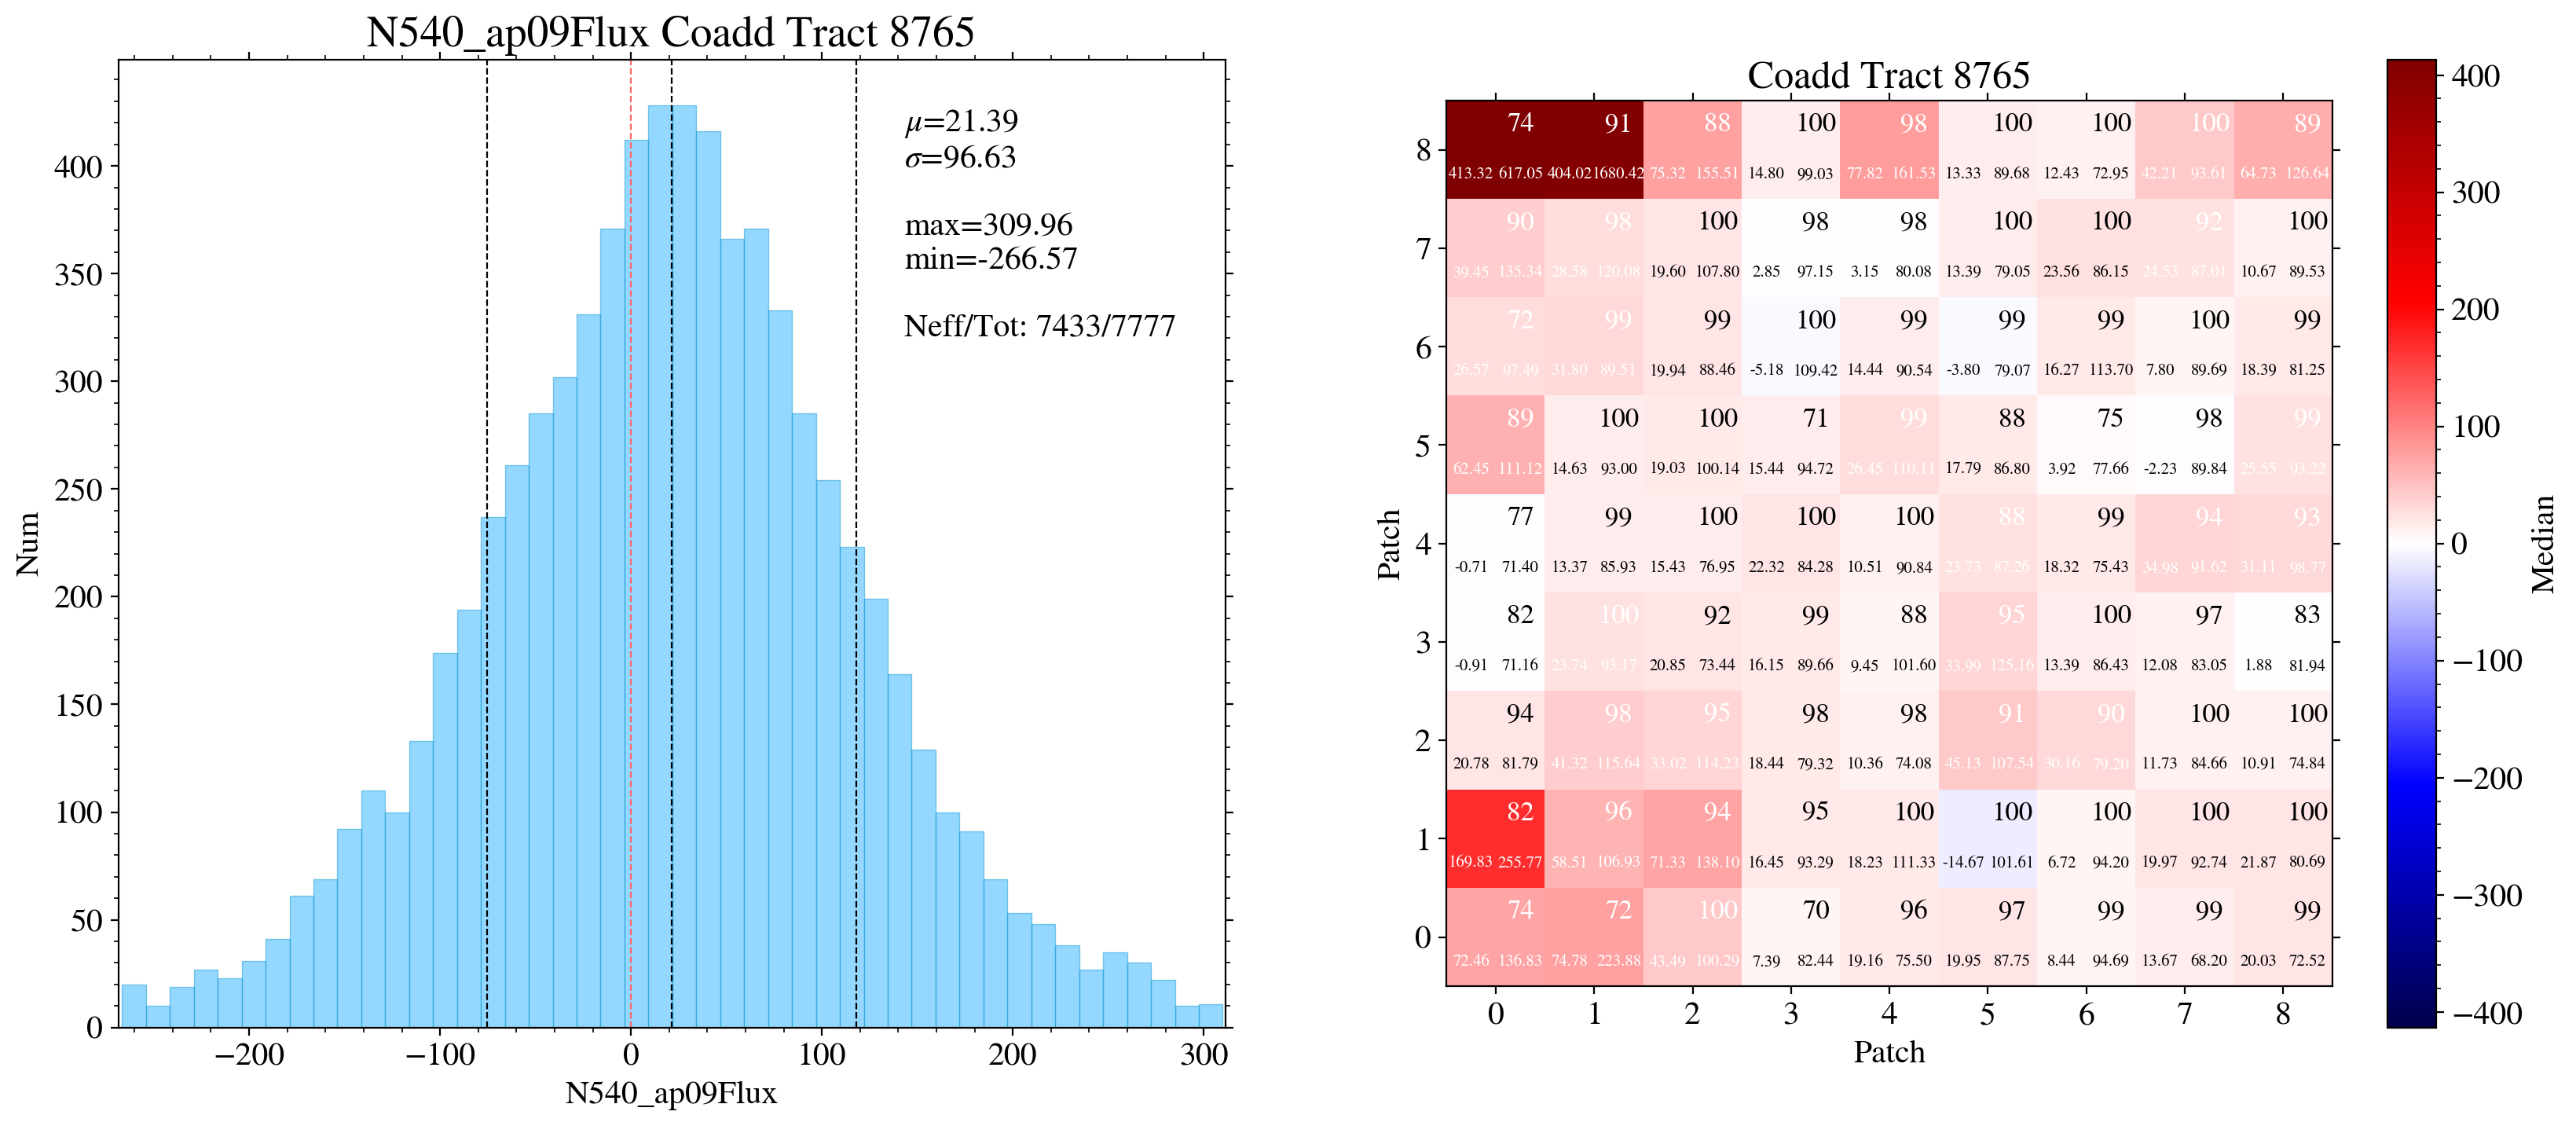

In [14]:
# set fname = None so that show the plot in the notebook
median, std, mid_patch, std_patch = plot_coadd2d_oneTract(skyobj_cat,tract = tract,colname = 'N540_ap09Flux', fname=None)

**STEP4**

Let's look at the sky object flux distribution  patch by patch

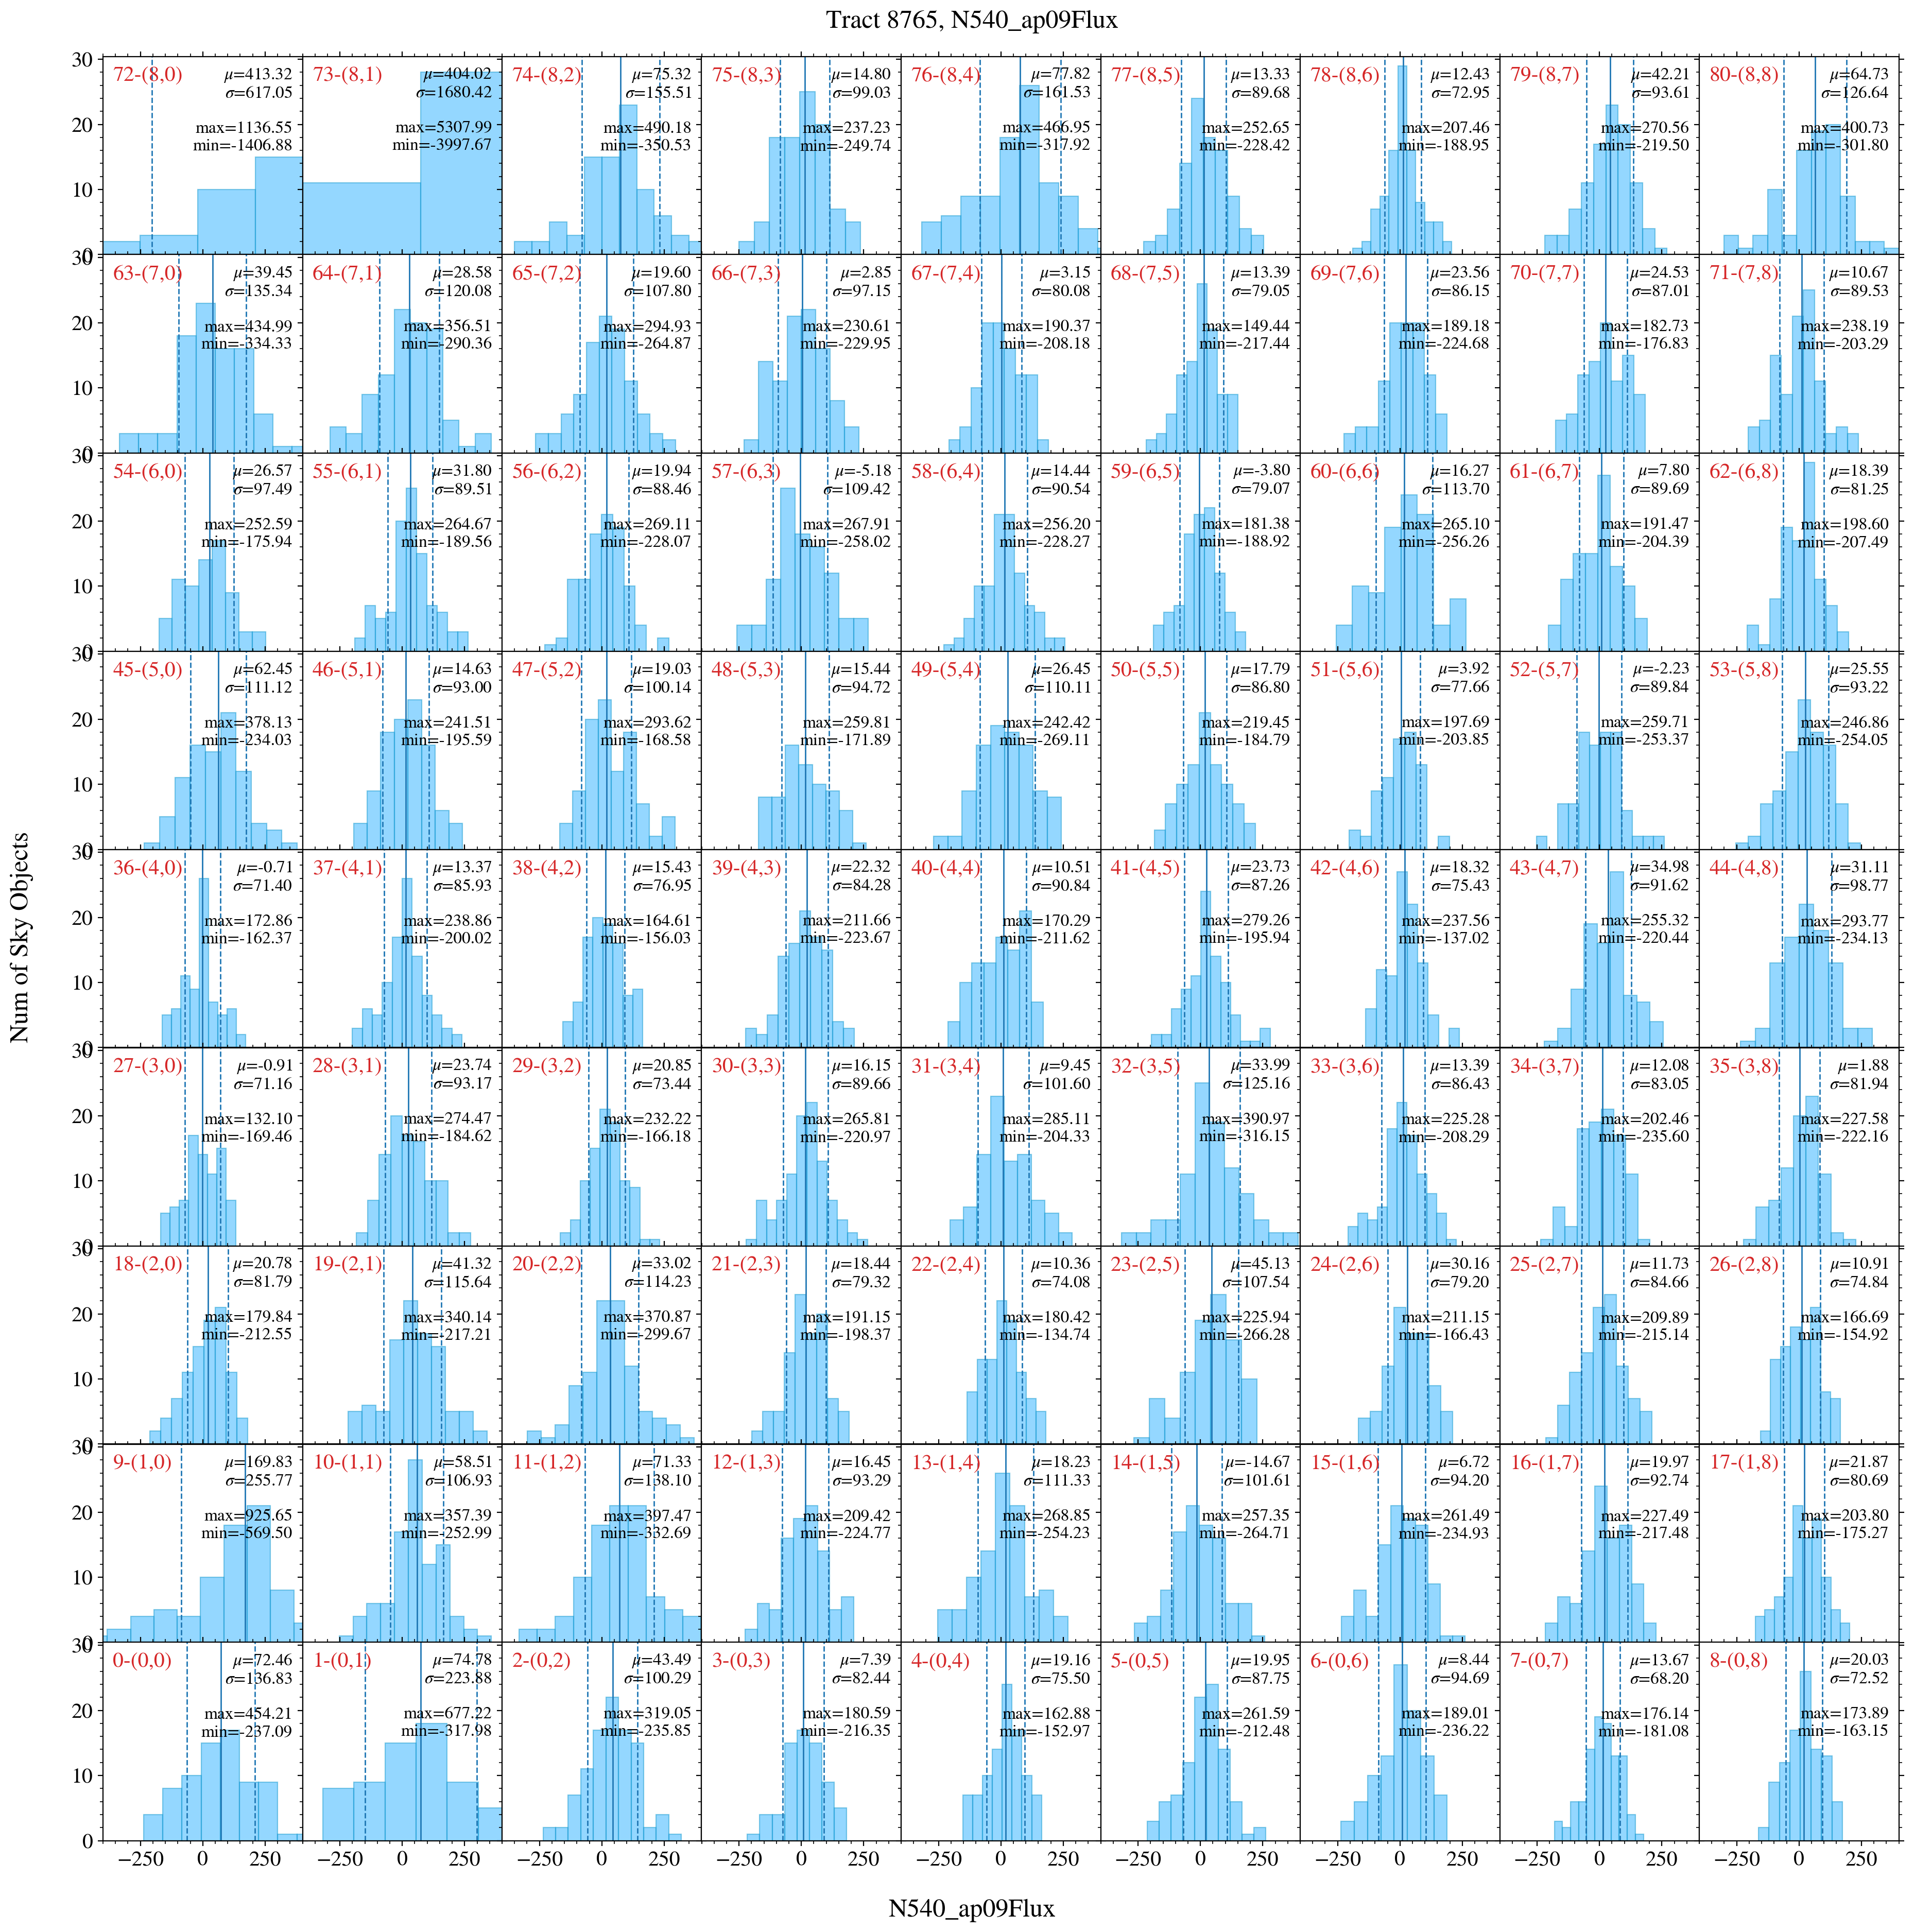

In [27]:
patch_list = np.unique(skyobj_cat['patch'])


colname = 'N540_ap09Flux'

fig, axes = plt.subplots(9,9, figsize=(9*2.5,9*2.5), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0,wspace=0)


xlim = [-400,400]

# ---------------- Loop over patches -----------#
for patch_id in patch_list:

        # load the skyobj catalog for this patch
        patch_cat = skyobj_cat[skyobj_cat['patch']==patch_id]
        patch_flux_raw = patch_cat[colname]
        mask, patch_flux = sigmaclip(patch_flux_raw)
        Neff = len(patch_flux)
        
        # calculate the median and std of the flux
        mid_flux = np.nanmedian(patch_flux)
        std_flux = np.sqrt(np.nanmean((patch_flux-mid_flux)**2))
        max_flux = np.nanmax(patch_flux)
        min_flux = np.nanmin(patch_flux)
        
        # plot the histogram
        nrow = patch_id//9
        ncol = patch_id%9


        ax = axes[8-nrow][ncol]
        ax.hist(patch_flux,bins='auto',facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.8,alpha=0.5)
        ax.axvline(mid_flux,ls='-',color='tab:blue',lw=1)
        ax.axvline(mid_flux - std_flux,ls='--',color='tab:blue',lw=1)
        ax.axvline(mid_flux + std_flux,ls='--',color='tab:blue',lw=1)
        ax.text(0.95,0.95,s='$\mu$=%.2f\n$\sigma$=%.2f\n\nmax=%.2f\nmin=%.2f'%(mid_flux,std_flux,max_flux,min_flux),transform=ax.transAxes,va='top', ha='right', fontsize=12)
        ax.text(0.05, 0.95, s='%d-(%d,%d)'%(patch_id, nrow, ncol), transform=ax.transAxes,va='top', ha='left', fontsize=15, color='tab:red')

        ax.set_xlim(xlim[0], xlim[-1])

_ = fig.suptitle('Tract %d, %s'%(tract,colname), y=0.9)
_ = fig.supxlabel('N540_ap09Flux', x=0.5, y=0.075)
_ = fig.supylabel('Num of Sky Objects', x=0.085, y=0.5)

Show the violin plot of sky object flux patch by patch.

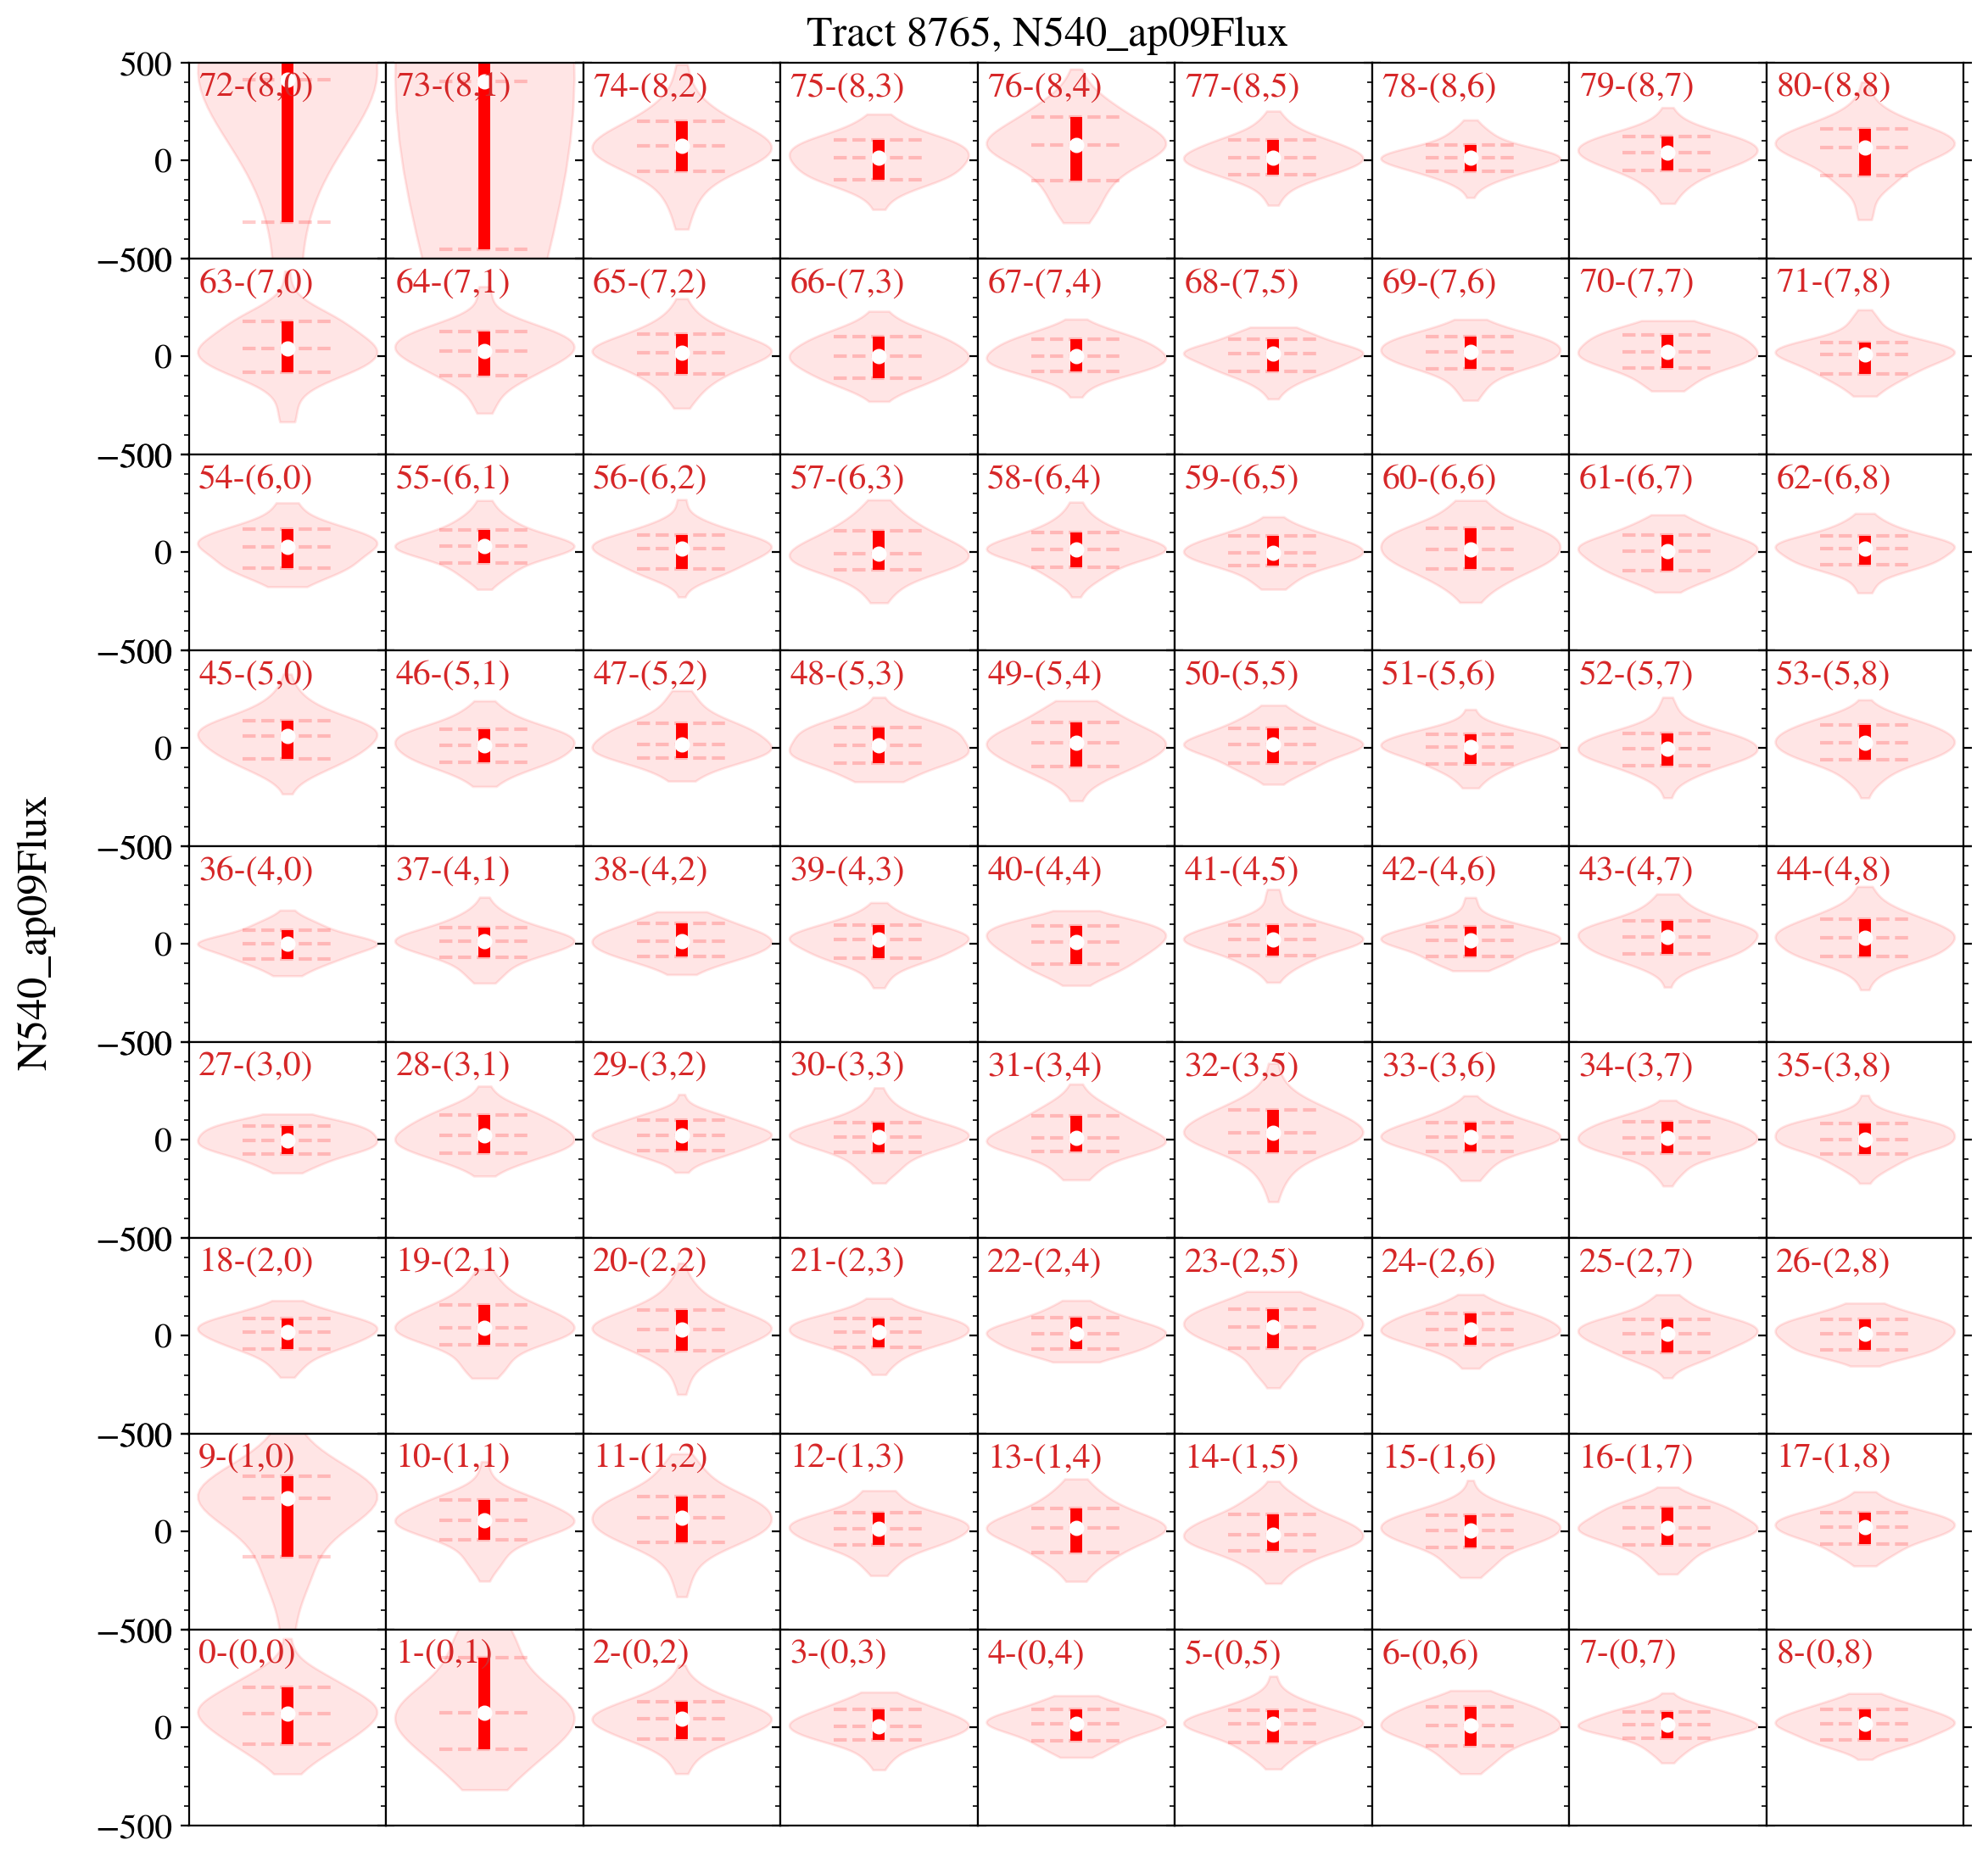

In [32]:

violin_fig, violin_axes = plt.subplots(9, 9, figsize=(9*1.5, 9*1.5), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0,wspace=0)

for patch_id in patch_list:

        # load the skyobj catalog for this patch
        patch_cat = skyobj_cat[skyobj_cat['patch']==patch_id]
        patch_flux_raw = patch_cat[colname]
        mask, patch_flux = sigmaclip(patch_flux_raw)
        Neff = len(patch_flux)
        
        # calculate the median and std of the flux
        mid_flux = np.nanmedian(patch_flux)
        std_flux = np.sqrt(np.nanmean((patch_flux-mid_flux)**2))
        max_flux = np.nanmax(patch_flux)
        min_flux = np.nanmin(patch_flux)

        # plot the violin plot
        nrow = patch_id//9
        ncol = patch_id%9
        
        ax = violin_axes[8-nrow][ncol]
        plot_violin(ax,  patch_flux, 1)

        ax.set_ylim(-500,500)
        ax.set_xticks([])
        ax.text(0.05, 0.95, s='%d-(%d,%d)'%(patch_id, nrow, ncol), transform=ax.transAxes,va='top', ha='left', fontsize=15, color='tab:red')

_ = violin_fig.suptitle('Tract %d, %s'%(tract,colname), y=0.9)
 
_ = violin_fig.supylabel('N540_ap09Flux', x=0.05, y=0.5)